In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

# Global variables

In [2]:
nameMagnet = 'D1'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = True

# Generate magnet geometry parsing .data and .cadata files

VERSION 10.2.1
'The new D1                                                                         '
'roxie_q_all_MSMod4.bhdata                                                          '
'../datab/roxie.cadata                                                              '
'20170608_FTH11_T90R190_T25f34R180_st.iron                                          '

&OPTION
  LEND=F     LWEDG=F    LPERS=F    LQUENCH=F  LALGO=F    LQUENCH0D=F
  LMIRIRON=F LBEMFEM=T  LPSI=F     LSOLV=F    LIRON=T    LMORPH=F   
  LHARD=F    LPOSTP=F   LPEAK=T    LINMARG=F  LMARG=F    LSELF=T    
  LMQE=F     LINDU=F    LEDDY=F    LSOLE=F    LFLUX=F    LFIELD3=F  
  LFISTR=F   LSELF3=F   LBRICK=F   LLEAD=F    LVRML=F    LOPERA=F   
  LOPER20=F  LANSYS=F   LRX2ANS=F  LANS2RX=F  LDXF=F     LMAP2D=T   
  LMAP3D=F   LEXPR=F    LFIL3D=F   LFIL2D=F   LCNC=F     LANSYSCN=F 
  LWEIRON=F  LCATIA=F   LEXEL=T    LQVOLT=F   LAXIS=T    LIMAGX=F   
  LIMAGY=F   LRAEND=F   LMARKER=F  LROLER2=F  LROLERP=F  LIMAGZZ=F  
  LSUPP=F  

<IPython.core.display.Javascript object>


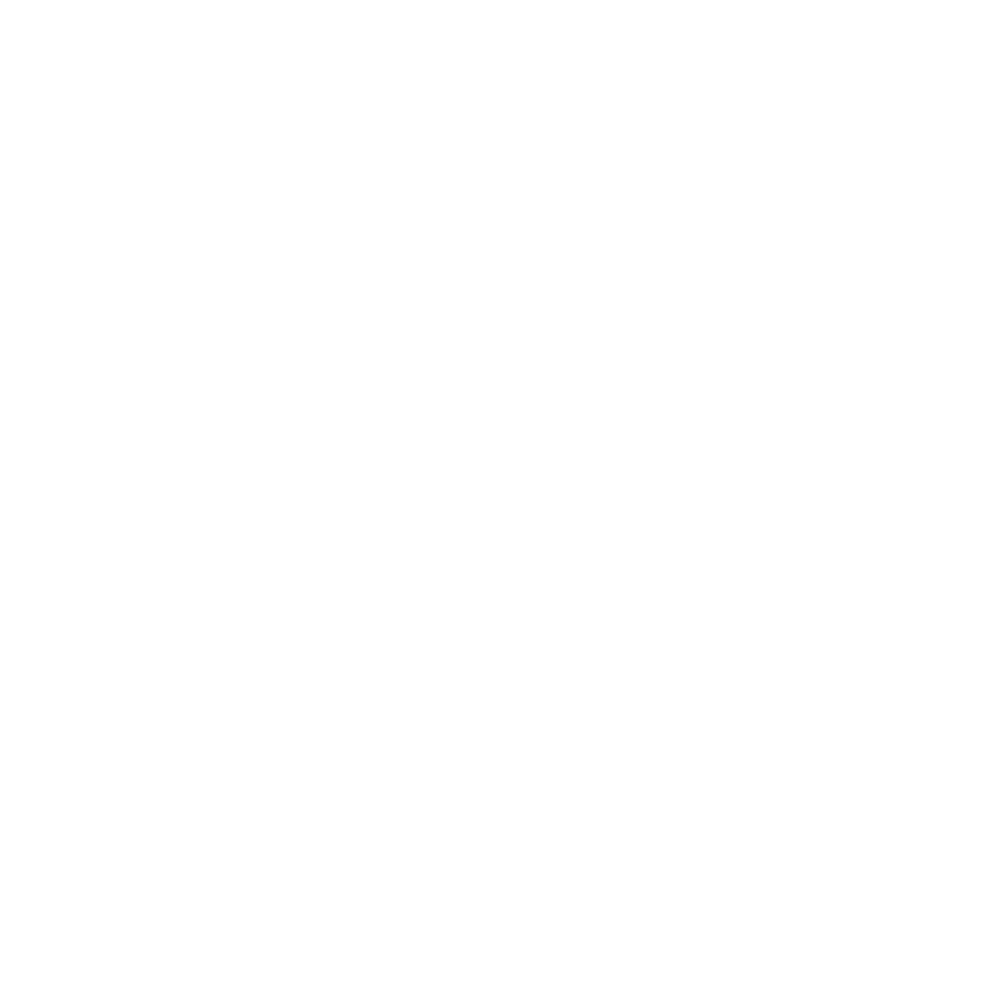

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Plot conductors and their numbers
%matplotlib notebook
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()


# Calculate magnetic field lines

<IPython.core.display.Javascript object>


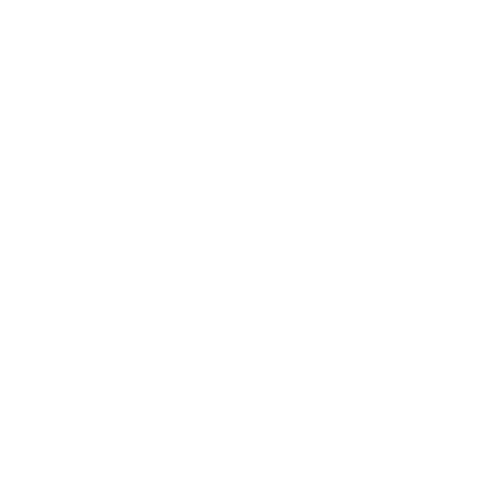

(-0.16499999999999998,
 0.16499999999999998,
 -0.16499999999999998,
 0.16499999999999998)

In [4]:
minMaxX = [-.15, +.15] # to adjust depending on the coil dimensions
minMaxY = [-.15, +.15] # to adjust depending on the coil dimensions
nGridPoints=[20, 20]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 6336
Peak magnetic field in the field-map from ROXIE = 6.596519110106482 T


<IPython.core.display.Javascript object>


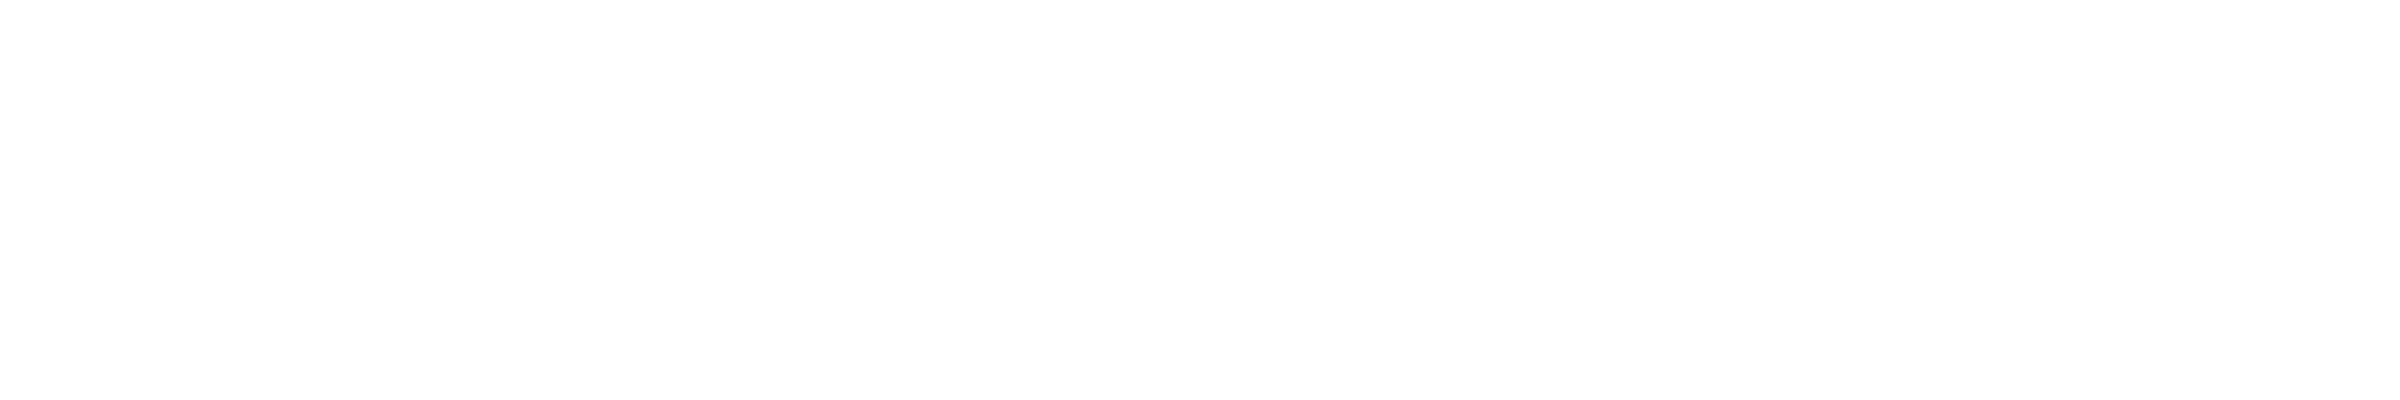

In [5]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


# Manipulate imported strand positions

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Total number of strands = 6336
Total number of half-turns = 176
Total number of turns = 88
Total number of groups = 16


<IPython.core.display.Javascript object>


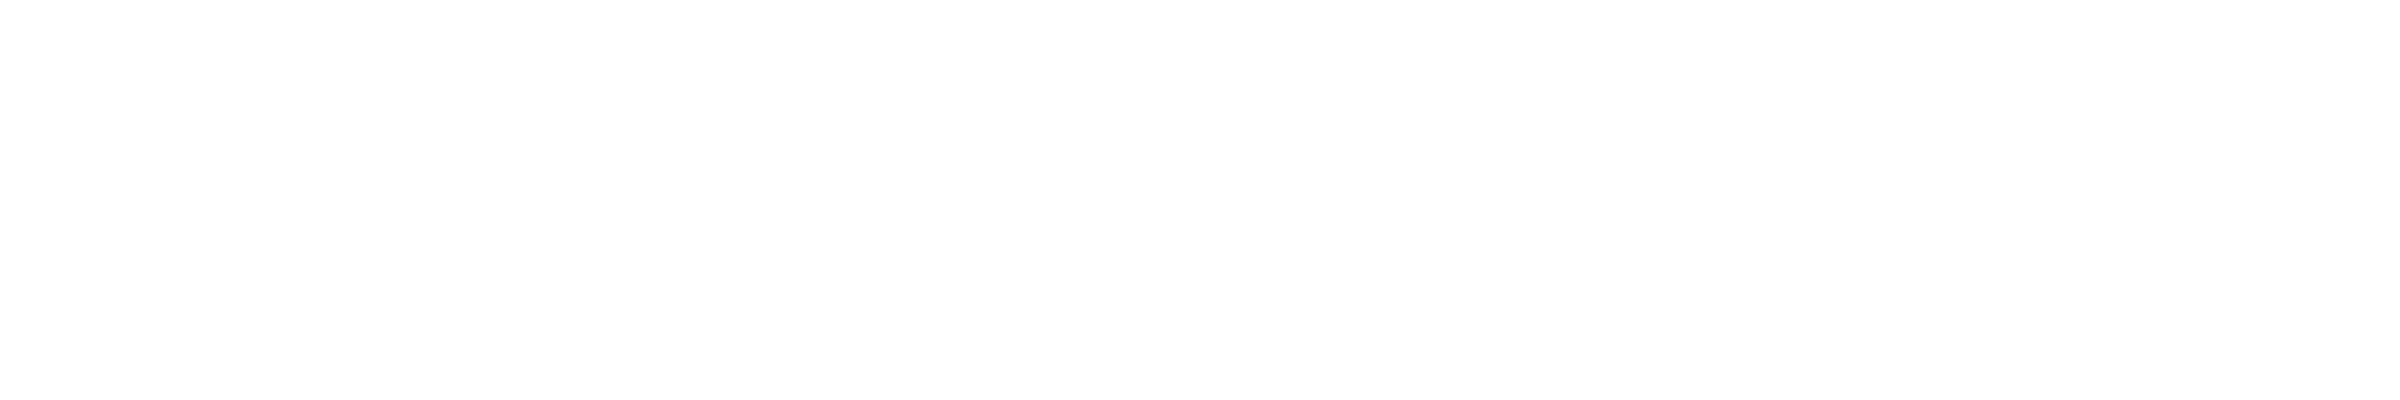

In [6]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
%matplotlib notebook
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [7]:
T00 = 1.9
l_magnet = 6.260
I00 = 12047

# Definition of groups of conductors

1 coil sections defined.
16 groups defined.


<IPython.core.display.Javascript object>


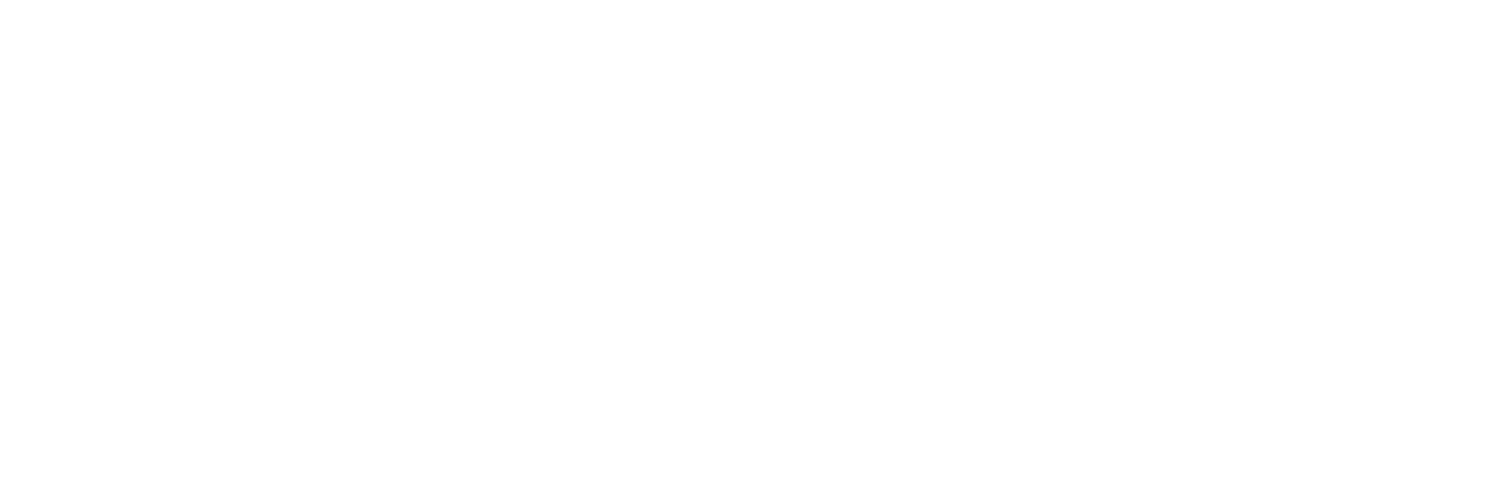

(-0.09943482478527965,
 0.09943482478527965,
 -0.0961385316488729,
 0.0961385316488729)

In [8]:
GroupToCoilSection = nGroups * [1]
polarities_inGroup = int(nGroups/4) * [-1] + int(nGroups/4) * [+1] + int(nGroups/4) * [+1] + int(nGroups/4) * [-1]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor parameters in each group

In [9]:
# Number of half-quadrants
nHalfQuadrants = 4
nGroupsPerQuadrant = 4

# Number of half-turns in each group
nT = nHalfQuadrants * [19, 13, 8, 4]
# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [36]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [l_magnet]
# strand diameter [m]
ds_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.825E-3]
# filament diameter [m]
df_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [6E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1/(1+1.95)]
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1] # guess value
# Filament twist-pitch [m]
Lp_f_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.015]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [150/293*273]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [3]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# bare cable width [m]
wBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [15.1E-3]
# bare average cable height [m]
hBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1.48E-3]
# insulation thickness in the width direction [m]
wIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [155E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [130E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100E-3]
# Cross-contact resistance [Ohm]
R_c_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100E-6] # guess value
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [9.2]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [14.5]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [65821.9]
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [-5042.6]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]

# fitParameters_inGroup - Based on data from MB_mod_2d_iron10.2.1 - with magnetization calculation2
fitParameters_inGroup= np.array(nHalfQuadrants * (nGroupsPerQuadrant * [[9.2, 14.5, 1874.857436, -142.2174817, 5221.781725, 1.360946738, 7774.3314, 12.00739691]])).transpose()
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup= nHalfQuadrants * nGroupsPerQuadrant * [3]

nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 3E-3
insulationAroundCables = 130E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

176 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.07975460122699386


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[1, 9], [2, 10], [3, 11], [4, 12], [16, 8], [15, 7], [14, 6], [13, 5]]


<IPython.core.display.Javascript object>


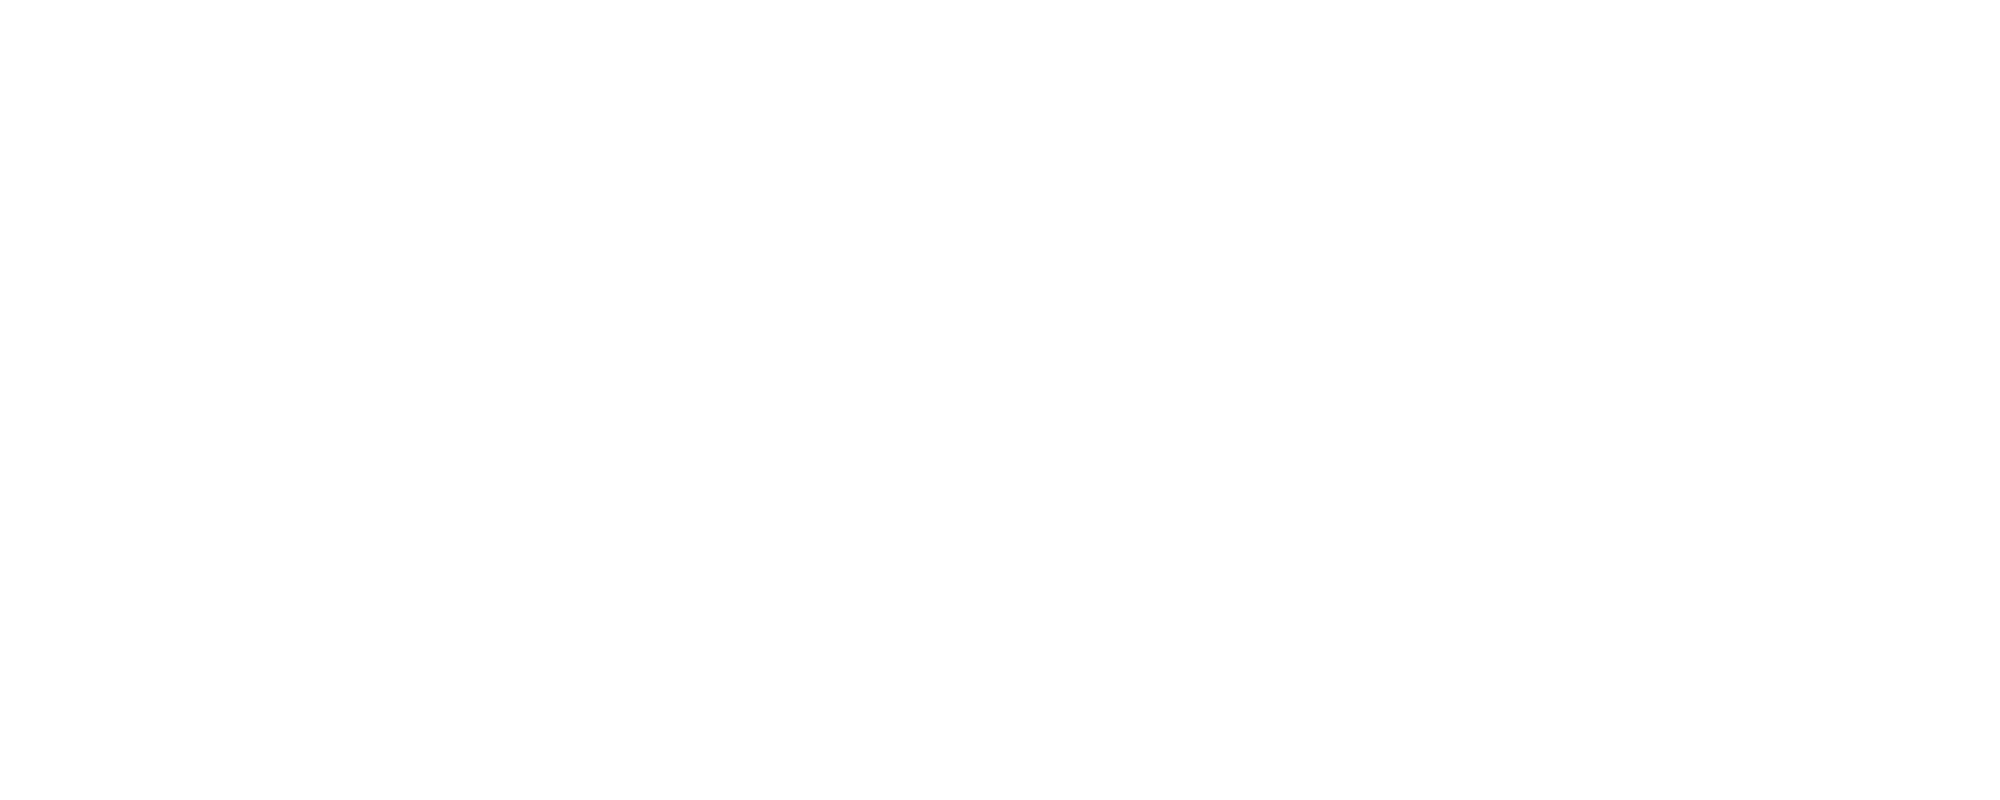

Calculated electrical order of the half-turns:
el_order_half_turns = [1, 89, 2, 90, 3, 91, 4, 92, 5, 93, 6, 94, 7, 95, 8, 96, 9, 97, 10, 98, 11, 99, 12, 100, 13, 101, 14, 102, 15, 103, 16, 104, 17, 105, 18, 106, 19, 107, 20, 108, 21, 109, 22, 110, 23, 111, 24, 112, 25, 113, 26, 114, 27, 115, 28, 116, 29, 117, 30, 118, 31, 119, 32, 120, 33, 121, 34, 122, 35, 123, 36, 124, 37, 125, 38, 126, 39, 127, 40, 128, 41, 129, 42, 130, 43, 131, 44, 132, 176, 88, 175, 87, 174, 86, 173, 85, 172, 84, 171, 83, 170, 82, 169, 81, 168, 80, 167, 79, 166, 78, 165, 77, 164, 76, 163, 75, 162, 74, 161, 73, 160, 72, 159, 71, 158, 70, 157, 69, 156, 68, 155, 67, 154, 66, 153, 65, 152, 64, 151, 63, 150, 62, 149, 61, 148, 60, 147, 59, 146, 58, 145, 57, 144, 56, 143, 55, 142, 54, 141, 53, 140, 52, 139, 51, 138, 50, 137, 49, 136, 48, 135, 47, 134, 46, 133, 45]


In [10]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [1,9], [2,10], [3,11], [4,12], [16,8], [15,7], [14,6], [13,5] ]
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 0, 0, 1, 1, 1, 1 ]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)



# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = {}'.format(el_order_half_turns))

<img src="MO_electricalOrder.png" width="750"/>

# Cable geometry parameters

In [11]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = nHalfQuadrants * [0, 0.895529903497625, 1.79105980699525, 2.68658971049288, 3.5821196139905, 4.47764951748813, 5.37317942098575, 6.26870932448338, 7.164239227981, 8.05976913147863, 8.95529903497625, 9.85082893847388, 10.7463588419715, 11.6418887454691, 12.5374186489668, 13.4329485524644, 14.328478455962, 15.2240083594596, 16.1195382629573, 26, 26.8955299034976, 27.7910598069952, 28.6865897104929, 29.5821196139905, 30.4776495174881, 31.3731794209857, 32.2687093244834, 33.164239227981, 34.0597691314786, 34.9552990349762, 35.8508289384739, 36.7463588419715, 50.2969, 51.1924299034976, 52.0879598069953, 52.9834897104929, 53.8790196139905, 54.7745495174881, 55.6700794209858, 56.5656093244834, 68.0015, 68.8970299034976, 69.7925598069953, 70.6880897104929 ]
# Rotate cable by a certain angle [deg]
rotation_block = \
int(nHalfTurnsDefined/4) *[  0] + \
int(nHalfTurnsDefined/4) *[180] + \
int(nHalfTurnsDefined/4) *[ 90] + \
int(nHalfTurnsDefined/4) *[270]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = int(nHalfTurnsDefined/2) * [0] + int(nHalfTurnsDefined/2) * [1]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]

if len(alphasDEG)!=nHalfTurnsDefined:
    raise Exception('Length of the vector alphasDEG ({}) must be equal to nHalfTurnsDefined={}.'.format(len(alphasDEG),nHalfTurnsDefined))
if len(rotation_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector rotation_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(rotation_block),nHalfTurnsDefined))
if len(mirror_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirror_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirror_block),nHalfTurnsDefined))
if len(mirrorY_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirrorY_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirrorY_block),nHalfTurnsDefined))

# Heat exchange between half-turns along the cable wide side

In [12]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175]
iContactAlongWidth_To = 
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 

# Heat exchange between half-turns along the cable narrow side

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1, 45]
iContactAlongWidth_To = 
[133, 89]


<IPython.core.display.Javascript object>


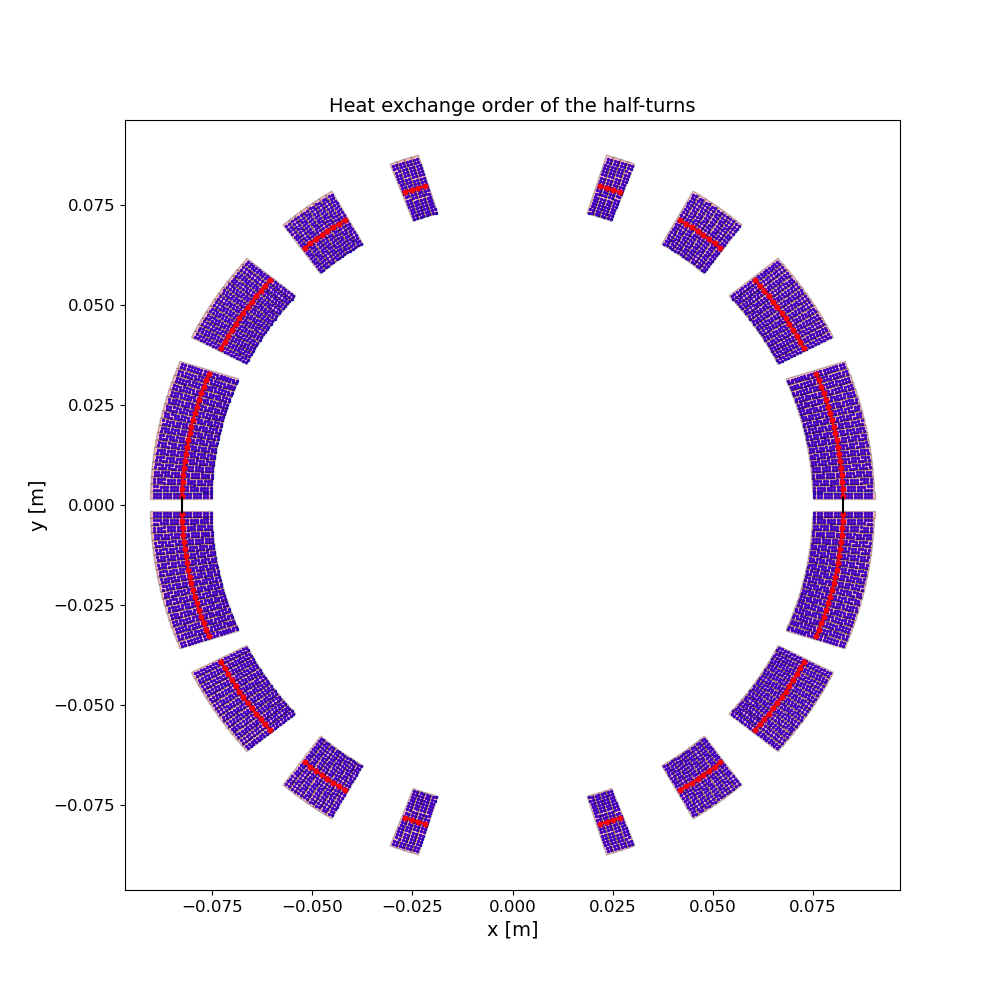

(-0.09943482478527965,
 0.09943482478527965,
 -0.0961385316488729,
 0.0961385316488729)

In [13]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 5E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

    
# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

%matplotlib notebook
plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Quench initiation calculation: Force selected half-turns to quench

In [14]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [9999]

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [15]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.000
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.000
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.000

# Power supply control

<IPython.core.display.Javascript object>


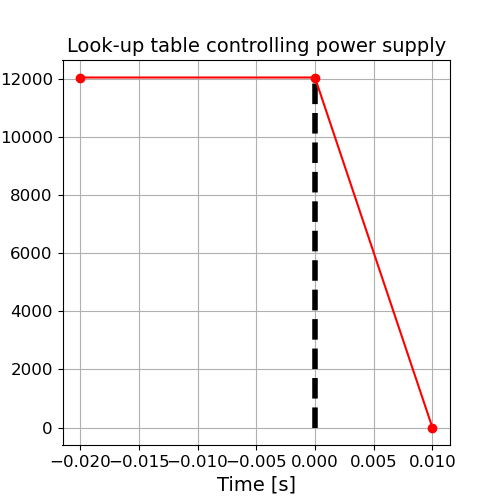

In [16]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Energy-extraction system

In [17]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 10E-6

# CLIQ system

In [18]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# D1 Quench Heaters

# IMPORTANT NOTES
The design of the D1 quench heater strips features a zig-zag pattern that aims at covering different half-turns at different longitudinal positions.
In reality, the QH strips heat up different blocks of turns for Section A and B (see figure).

In the LEDET 2D model, this is reproduced by modeling one cross-section whose turns are heated up by strips both in Section A and B.
Each of the four quench heater circuits (composed of 2 strips in series) is modeled with THREE quench heater strips.
- #1 One strip heats the 3rd block of half-turns for Section A (see figure)
- #2 One strip heats the 1st block of half-turns for Section B (see figure)
- #3 One strip heats the 2nd block of half-turns for Sections A and B (see figure). Note: it would be a mistake to add twice this strip, because the model is 2D, hence it

To obtain correct QH peak current and discharge time constant, the following changes are applied to the parameters of strips of type #1 and #2 (see above):
- voltage applied to each QH circuit is divided by 4
- QH power-supply capacitance is multiplied by 4
- QH circtuit warm resistance is divided by 4
- QH strip length is divided by 2

To obtain the correct QH peak current and discharge time constant, the following changes are applied to the parameters of strips of type #3 (see above):
- voltage applied to each QH circuit is divided by 2
- QH power-supply capacitance is multiplied by 2
- QH circtuit warm resistance is divided by 2
- QH strip length is unchanged

The QH warm resistances and stainless-steel resistivity are selected so as to achieve the design power density of about 120 W/cm^2 (from "D1 update", HL-LHC Collaboration Meeting, 2019)

<img src="D1_QH_positions.png" width="750"/>

# Quench heater parameters

In [19]:
# Number of quench heater strips to write in the file
nHeaterStripCircuits = 4
nHeaterStrips = nHeaterStripCircuits * 3

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStripCircuits * [.002, .002, .002]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStripCircuits * [900/4, 900/4, 900/2]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStripCircuits * [.00705*4, .00705*4, .00705*2]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStripCircuits * [.75/4, .75/4, .75/2]
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStripCircuits * [.015, .015, .015]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStripCircuits * [25E-6, 25E-6, 25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStripCircuits * [75E-6, 75E-6, 75E-6]
# Type of material of the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStripCircuits * [2, 2, 2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStripCircuits * [500E-6, 500E-6, 500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStripCircuits * [2, 2, 2]
# Length of the QH strip.
l_QH = nHeaterStripCircuits * [6.26/2, 6.26/2, 6.26]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStripCircuits * [.1/(.1+.14), .1/(.1+.14), .1/(.1+.14)]


############################################################################################################
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
fScaling_RhoSS_Defined = 1.00
rhoSS = 5.00E-07 * fScaling_RhoSS_Defined # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])

print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))

I0_QH=[116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639, 116.79884643114639]
tau_QH=[0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665, 0.05432416666666665]


# Heat exchange between quench heater strips and half-turns

<IPython.core.display.Javascript object>


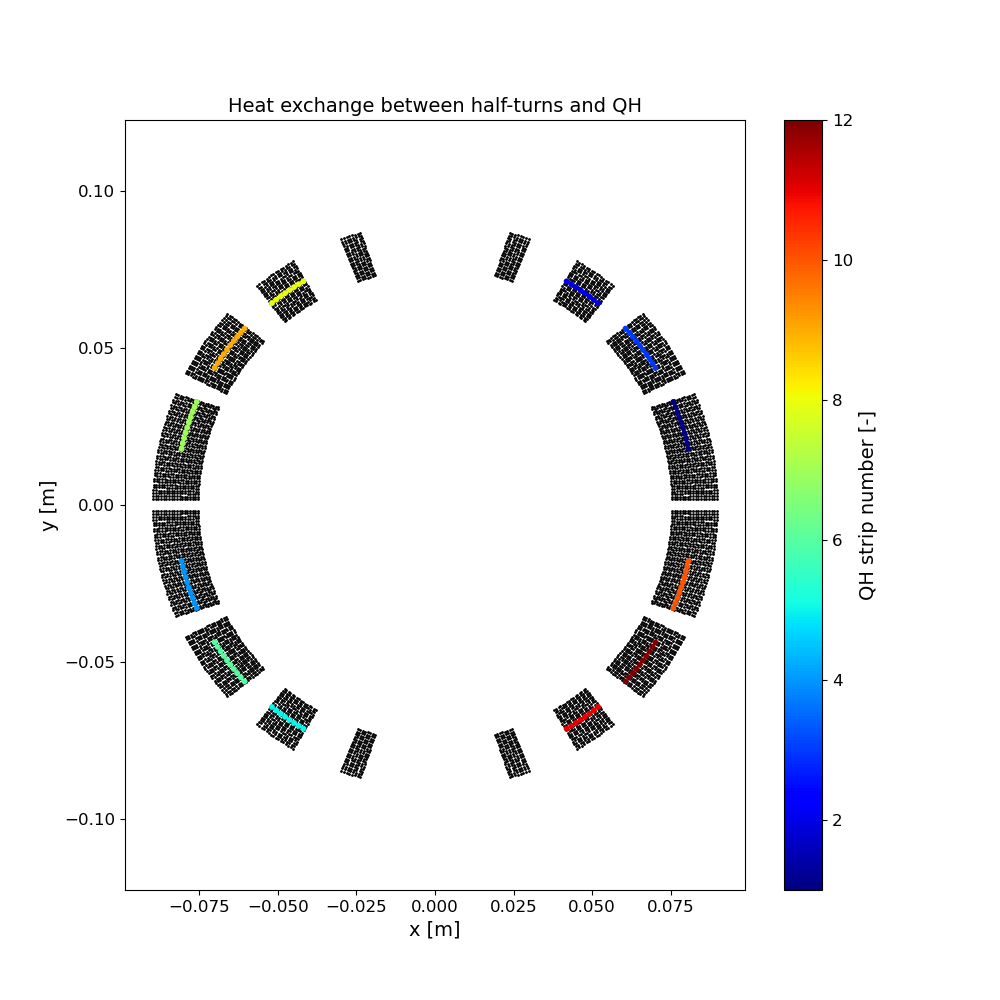

iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
iQH_toHalfTurn_To = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36, 37, 38, 39, 40, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 77, 78, 79, 80, 81, 82, 83, 84, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 121, 122, 123, 124, 125, 126, 127, 128, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 165, 166, 167, 168, 169, 170, 171, 172, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164]


In [20]:
# Thermal connections between heater strips and half-turns are manually defined for one half-quadrant and then automatically extended to the other half-quadrants
iQH_toHalfTurn_From_oneHalfQuadrant = 10*[1] + 8*[2] + 10*[3]
iQH_toHalfTurn_To_oneHalfQuadrant = list(range(10,19+1)) + list(range(33,40+1)) + list(range(23,32+1))

nHalfTurnsinHQ = sum(nT[0:4])
nQH_oneHalfQuedrant = 3


# Automatically extend to the other half-quadrants
iQH_toHalfTurn_To=[]
iQH_toHalfTurn_From=[]
for i in range (0,nHalfQuadrants):
    iQH_tempVector_To = list(np.asarray(iQH_toHalfTurn_To_oneHalfQuadrant) + i*nHalfTurnsinHQ)
    iQH_toHalfTurn_To.extend(iQH_tempVector_To)
    
    iQH_tempVector_From = list(np.asarray(iQH_toHalfTurn_From_oneHalfQuadrant) + i*nQH_oneHalfQuedrant)
    iQH_toHalfTurn_From.extend(iQH_tempVector_From)
    
    
# Plot
iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)

f = plt.figure(figsize=(10,10))
plt.scatter(x, y,s=1, c='k')
plt.scatter(x_ave[iQH_toHalfTurn_To_Array-1], y_ave[iQH_toHalfTurn_To_Array-1], s=10, c=iQH_toHalfTurn_From_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange between half-turns and QH',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('QH strip number [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


print ('iQH_toHalfTurn_From = {}'.format(iQH_toHalfTurn_From))
print ('iQH_toHalfTurn_To = {}'.format(iQH_toHalfTurn_To))

# Adiabatic hot-spot temperature calculation

In [21]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [22]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.0036567636440308048 H/m


<IPython.core.display.Javascript object>


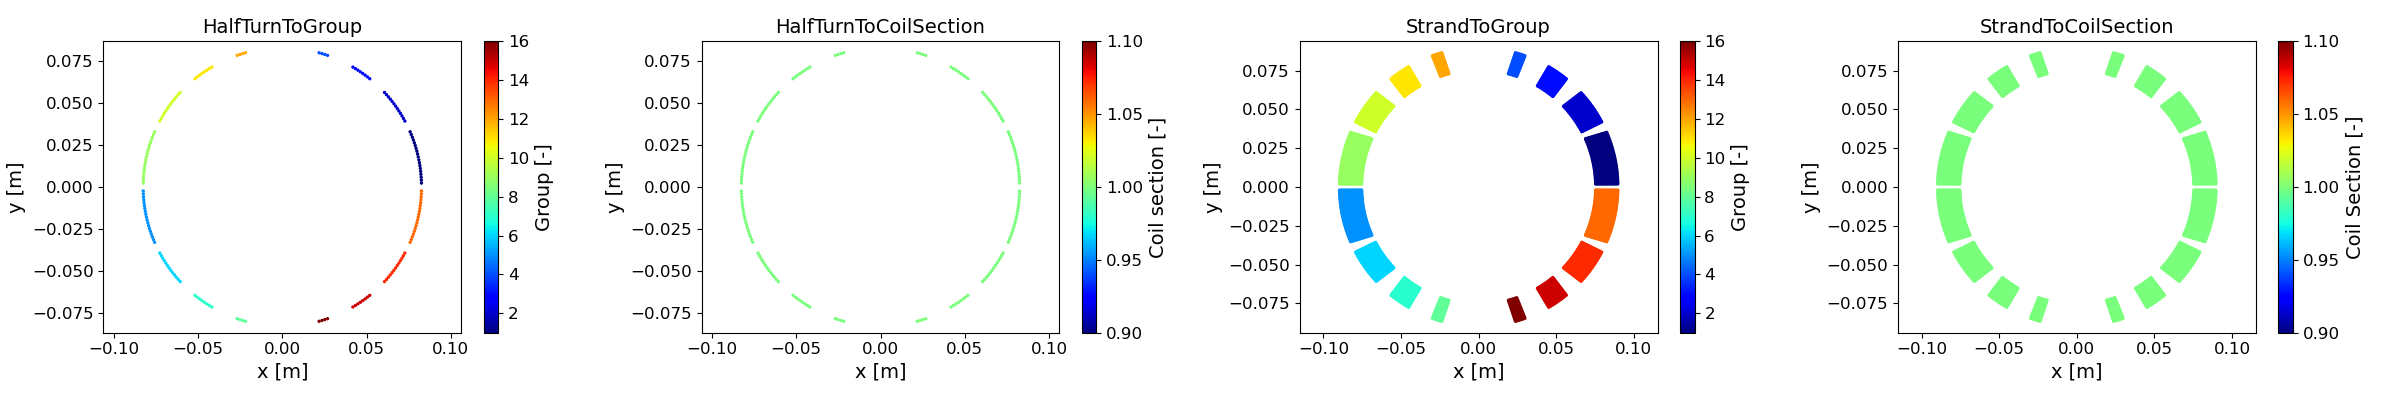

In [23]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

<IPython.core.display.Javascript object>


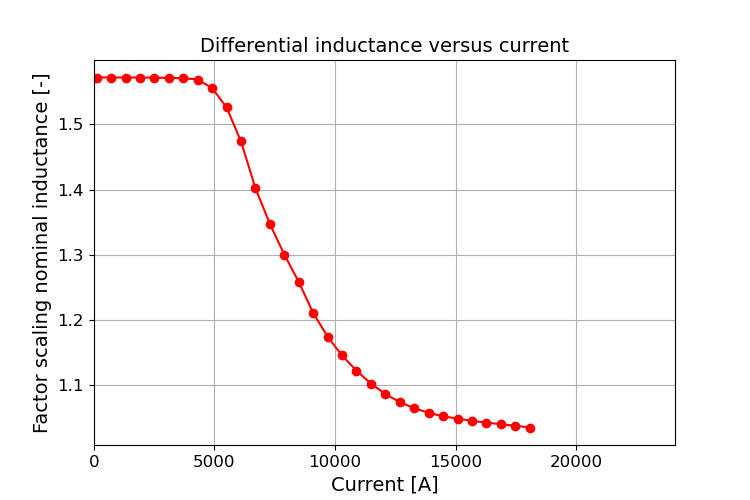

Differential inductance at lowest current level: 0.005747762980000013 H/m


In [24]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0, 120.47, 718.804333, 1317.13867, 1915.473, 2513.80733, 3112.14167, 3710.476, 4308.81033, 4907.14467, 5505.479, 6103.81333, 6702.14767, 7300.482, 7898.81633, 8497.15067, 9095.485, 9693.81933, 10292.1537, 10890.488, 11488.8223, 12087.1567, 12685.491, 13283.8253, 13882.1597, 14480.494, 15078.8283, 15677.1627, 16275.497, 16873.8313, 17472.1657, 18070.5 ]
fL_L = [1.57181692324646, 1.57181692324646, 1.57181692324646, 1.57181692324646, 1.57174842004954, 1.57160591699199, 1.57111350069844, 1.57083052916931, 1.56870451536126, 1.55555740642014, 1.52597050649112, 1.47378642554526, 1.40215859134614, 1.34748291649732, 1.30035527392154, 1.25851652389739, 1.21090707003395, 1.17455099320163, 1.14579576036846, 1.12236258876059, 1.10268100498705, 1.08666746796352, 1.07427426063278, 1.06480853810611, 1.05799428582577, 1.05242922557551, 1.04906964010707, 1.04553248505437, 1.04290867861403, 1.04034041308904, 1.0380122369123, 1.03533739627393 ]


# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

print('Differential inductance at lowest current level: {} H/m'.format(L_mag0 * fL_L[0]))

# Time Vector Definition

<IPython.core.display.Javascript object>


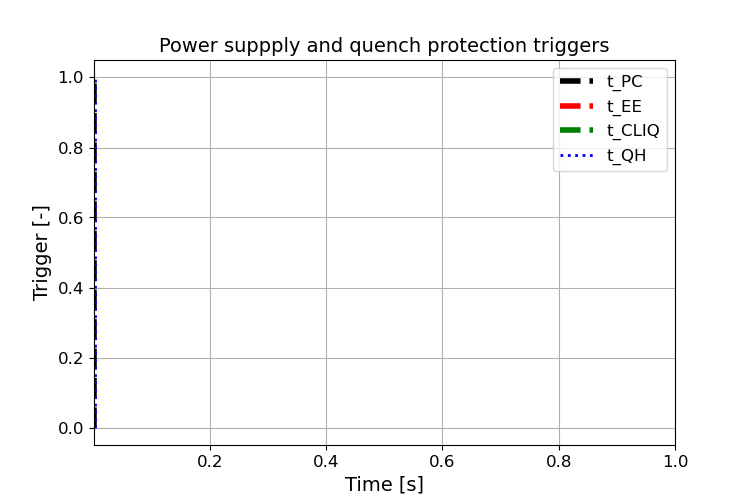

In [25]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.02, 5.0E-05, -0.001, -0.000950, 5.0E-05, 0.175, 0.1755, 5.00E-04, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [26]:
# Field-Map Files Options
Iref = I00
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.05
tau_increaseRis = 0.1
fScaling_RhoSS = fScaling_RhoSS_Defined # different from the often used 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 0
MinMaxXY_MTF = [-120, 120, -120, 120]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [27]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [28]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [29]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [30]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
Initial temperature [K]
T00 1.9
Magnetic length [m]
l_magnet 6.26
Initial current [A]
I00 12047
Define the coil section where each group of cables is located
GroupToCoilSection [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Polarity of the current in each group of strands
polarities_inGroup [-1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1]
Number of half-turns in each group
nT [19, 13, 8, 4, 19, 13, 8, 4, 19, 13, 8, 4, 19, 13, 8, 4]
Number of strands in each cable belonging to a particular group
nStrands_inGroup [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
length of each half turn [m] (default=l_magnet)
l_mag_inGroup [6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26, 6.26]
strand diameter [m]
ds_inGroup [0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825, 0.000825]
fraction of superconductor in 

# Write the LEDET input file

In [31]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Preliminary consistency check was successful! -  D1_0.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:00:33.006755
New file D1_0.xlsx generated.


Field maps: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
Minimum quench detection time = 8.641452836636445 ms
Maximum quench detection time = 32.33655379042854 ms
File D1vQ_I00.csv with calculated quench propagation velocities was written.


<IPython.core.display.Javascript object>


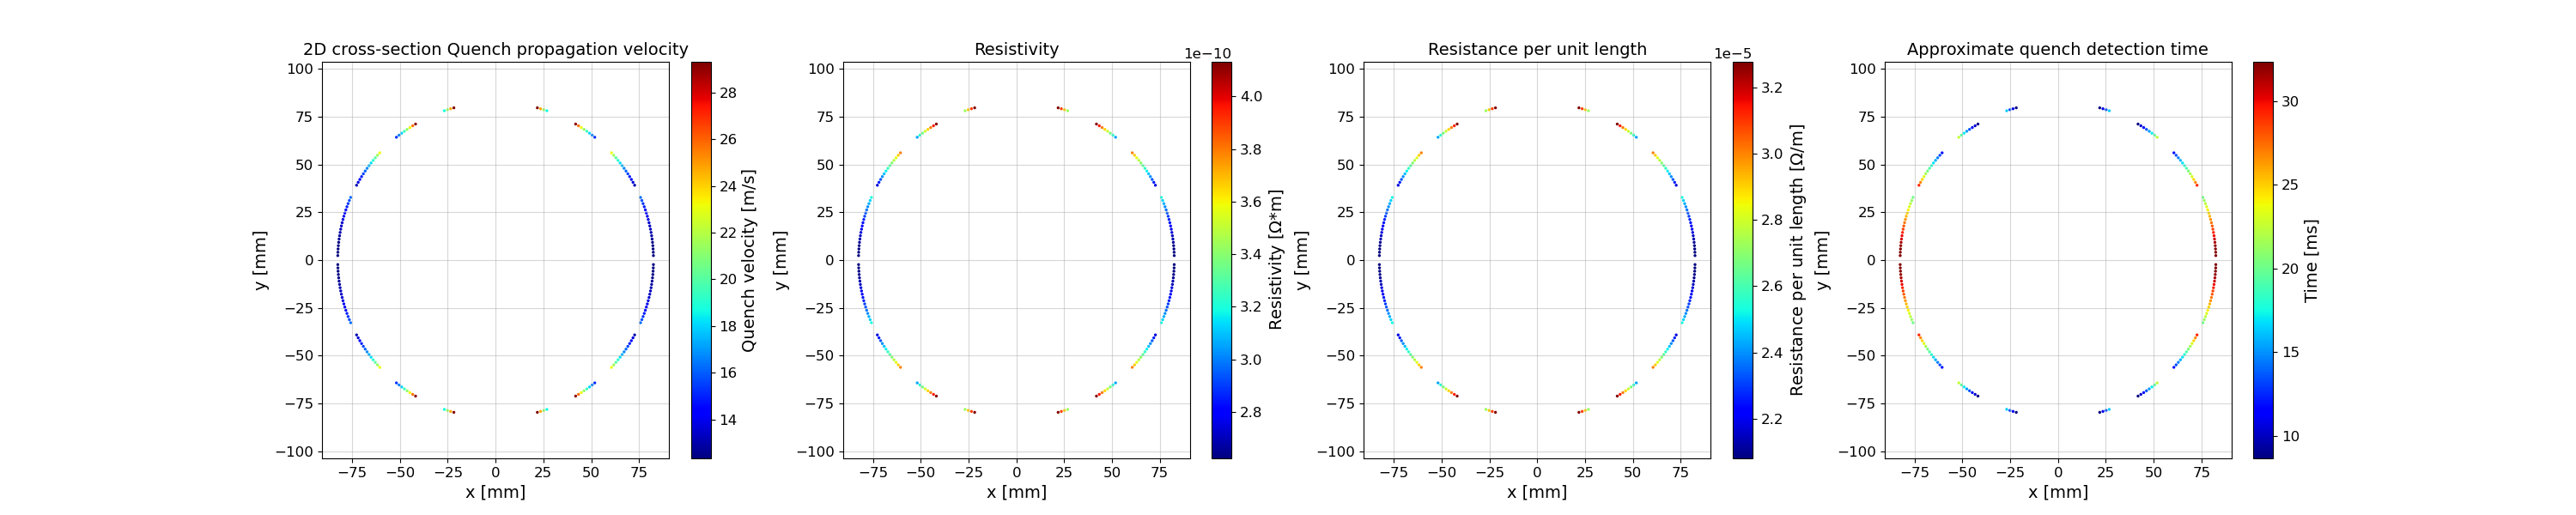

<IPython.core.display.Javascript object>


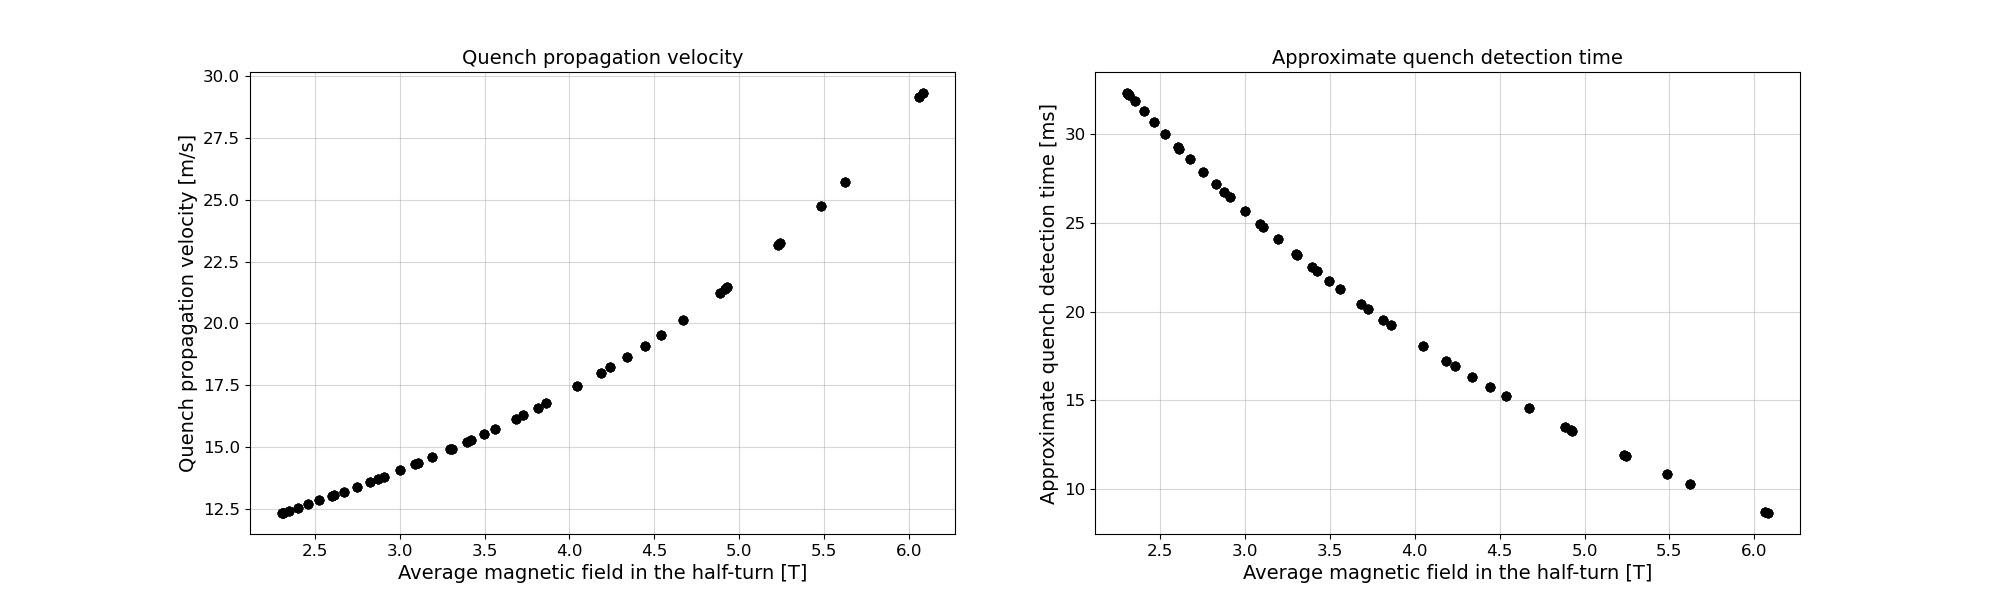

In [32]:
# Load default LEDET variable descriptions
paramLEDET_notebook = ParametersLEDET()

# Define quench detection threshold
uQuenchDetectionThreshold = 0.1 # [V]


# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # Experimental 2D + 1D model
# Indices of the half-turns that are set to quench at a given time
iStartQuench = list(range(1, nHalfTurnsDefined+1))
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]*nHalfTurnsDefined
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]*nHalfTurnsDefined
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
#vQ_iStartQuench = [99999]*(len(CondNumbers))
paramLEDET_notebook.localsParser(locals())
paramLEDET_notebook.adjust_vQ(nameMagnet+'_All_WithIron_WithSelfField.map2d')
vQ_iStartQuench = paramLEDET_notebook.getAttribute("Inputs","vQ_iStartQuench")

# Set the location and time of the quench
# halfTurn_start_quench = 1
# time_start_quench = -0.05
# tStartQuench[halfTurn_start_quench-1] = time_start_quench


# Calculate resistance of each turn at T=10 K
rho_Cu_10K = 1.7E-10 # [Ohm*m] Approximate Cu resistivity at T=10 K, B=0, for RRR=100 
rho_Cu_10K_B = 4E-11 # [Ohm*m/T] Approximate Cu magneto-resistivity factor
rho_ht_10K = []
r_el_ht_10K = []
mean_B_ht =[]
tQuenchDetection = []
for ht in range(1,nHalfTurns+1):
    current_group = HalfTurnToGroup[ht-1]
    
    mean_B = np.mean( B[np.where(strandToHalfTurn==ht)] ) /Iref*I00 # average magnetic field in the current half-turn
    rho_mean = rho_Cu_10K + rho_Cu_10K_B * mean_B # average resistivity in the current half-turn
    cross_section = nStrands_inGroup[current_group-1] * np.pi/4* ds_inGroup[current_group-1]**2 *(1-f_SC_strand_inGroup[current_group-1])
    
    # Electrical resistance per unit length
    r_el_m = rho_mean / cross_section
    
    # Approximate time to reach the quench detection threshold
    tQD = uQuenchDetectionThreshold / (vQ_iStartQuench[ht-1] * r_el_m *I00)
    
    mean_B_ht = np.hstack([mean_B_ht, mean_B])
    rho_ht_10K = np.hstack([ rho_ht_10K, rho_mean])
    r_el_ht_10K = np.hstack([ r_el_ht_10K, r_el_m])
    tQuenchDetection = np.hstack([ tQuenchDetection, tQD])

    
print('Minimum quench detection time = {} ms'.format(min(tQuenchDetection*1e3)))
print('Maximum quench detection time = {} ms'.format(max(tQuenchDetection*1e3)))
    
    
#### Write calculated quench propagation velocities to a .csv file
name_file_vQ = nameMagnet + 'vQ_I00' + '.csv'
np.savetxt(name_file_vQ, vQ_iStartQuench, delimiter=",")
print('File {} with calculated quench propagation velocities was written.'.format(name_file_vQ))


##### Plotting
f = plt.figure(figsize=(30,6))
plt.subplot(1, 4, 1 )
# fig, ax = plt.subplots()
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=vQ_iStartQuench)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('2D cross-section Quench propagation velocity',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Quench velocity [m/s]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2 )
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=rho_ht_10K)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('Resistivity',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Resistivity [$\Omega$*m]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3 )
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=r_el_ht_10K)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('Resistance per unit length',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Resistance per unit length [$\Omega$/m]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4 )
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=tQuenchDetection*1e3)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('Approximate quench detection time',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Time [ms]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')



##### Plotting
f = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1 )
plt.plot(mean_B_ht, vQ_iStartQuench, 'ko')
plt.xlabel('Average magnetic field in the half-turn [T]',**selectedFont)
plt.ylabel('Quench propagation velocity [m/s]',**selectedFont)
plt.title('Quench propagation velocity',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
plt.rcParams.update({'font.size': 12})

plt.subplot(1, 2, 2 )
plt.plot(mean_B_ht, tQuenchDetection*1e3, 'ko')
plt.xlabel('Average magnetic field in the half-turn [T]',**selectedFont)
plt.ylabel('Approximate quench detection time [ms]',**selectedFont)
plt.title('Approximate quench detection time',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
plt.rcParams.update({'font.size': 12})

# Persistent Currents

<IPython.core.display.Javascript object>


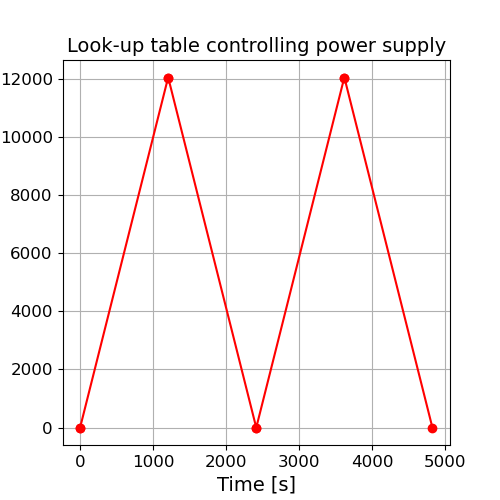

Preliminary consistency check was successful! -  D1_200.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:00:36.421138
New file D1_200.xlsx generated.


In [33]:
# This cell writes an input file for simulating a powering cycle

# Define input parameters 
I00 =  12047   # Amplitude of powering current Ia. Default: nominal current  
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0]   # Current LUT. Possible to do a positive-negative cycles as well 
dIdt = 10   # Current ramp rate 
timeStep = 0.25  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)